# Wildfires localization (Alaska 2004 - 2005)
## A proof of concept on a small area (WIP)
---------------------------------

*Add description of project*

Add the root directory of this project to the Python paths. The mlfire package is located there.

In [1]:
import sys
sys.path.append('..')

Import a functionality for lazy importing packages. The packages will be loaded using a lazy importing approach then.

In [2]:
from mlfire.utils.functool import lazy_import

In [3]:
data_view = lazy_import('mlfire.data.view')
data_ts = lazy_import('mlfire.data.ts')

features_pca = lazy_import('mlfire.features.pca')
utils_plt = lazy_import('mlfire.utils.plots')

## Get file names of images and labels

In [4]:
ee_collections = lazy_import('mlfire.earthengine.collections')
os = lazy_import('os')

A prefix of sources (satellite images and labels) and a location where images (GeoTIFFs) are placed.

In [5]:
DATA_DIR = '../data/tifs'
PREFIX_IMG = 'ak_reflec_january_december_{}_100km'

We use the MTBS labelling for wildfires in this example. See the Google Earth Engine catalog on https://developers.google.com/earth-engine/datasets/catalog/USFS_GTAC_MTBS_annual_burn_severity_mosaics_v1 for futher details.

In [6]:
LABEL_COLLECTION = ee_collections.FireLabelsCollection.MTBS
STR_LABEL_COLLECTION = LABEL_COLLECTION.name.lower()

Get filenames of satellite images and labels and store them to lists.

In [7]:
lst_satimgs = []
lst_labels = []

for year in range(2004, 2006):

    PREFIX_IMG_YEAR = PREFIX_IMG.format(year)

    fn_satimg = '{}_epsg3338_area_0.tif'.format(PREFIX_IMG_YEAR)
    fn_satimg = os.path.join(DATA_DIR, fn_satimg)
    lst_satimgs.append(os.path.abspath(fn_satimg))

    fn_labels = '{}_epsg3338_area_0_{}_labels.tif'.format(PREFIX_IMG_YEAR, STR_LABEL_COLLECTION)
    fn_labels = os.path.join(DATA_DIR, fn_labels)
    lst_labels.append(os.path.abspath(fn_labels))

List of satellite images.

In [8]:
print(lst_satimgs)

['/Users/marek/Playground/wildfires/data/tifs/ak_reflec_january_december_2004_100km_epsg3338_area_0.tif', '/Users/marek/Playground/wildfires/data/tifs/ak_reflec_january_december_2005_100km_epsg3338_area_0.tif']


List of labels.

In [9]:
print(lst_labels)

['/Users/marek/Playground/wildfires/data/tifs/ak_reflec_january_december_2004_100km_epsg3338_area_0_mtbs_labels.tif', '/Users/marek/Playground/wildfires/data/tifs/ak_reflec_january_december_2005_100km_epsg3338_area_0_mtbs_labels.tif']


## Data adapter

In [10]:
DatasetTransformOP = data_ts.DatasetTransformOP
DatasetSplitOpt = data_ts.DatasetSplitOpt
FactorOP = features_pca.FactorOP

**TODO add a comment**

In [11]:
TRANSFORM_OPS = [DatasetTransformOP.STANDARTIZE_ZSCORE, DatasetTransformOP.PCA]
PCA_OPS = [FactorOP.TEST_CUMSUM]

**TODO add a comment**

In [12]:
DS_SPLIT_OPT = DatasetSplitOpt.IMG_HORIZONTAL_SPLIT
TEST_RATIO = 1. / 3.

**TODO add a comment**

In [13]:
adapter_ts = data_ts.DataAdapterTS(
    lst_satimgs=lst_satimgs,
    lst_labels=lst_labels,
    label_collection=LABEL_COLLECTION,
    mtbs_severity_from=ee_collections.MTBSSeverity.LOW,
    # transformation options
    transform_ops=TRANSFORM_OPS,
    pca_ops=PCA_OPS,
    # data set split options
    ds_split_opt=DS_SPLIT_OPT,
    test_ratio=TEST_RATIO,
)

## Dates

In [14]:
adapter_ts.satimg_dates

Start event: 'Processing band dates (satellite images, modis, reflectance)'.
Finnish event: 'Processing band dates (satellite images, modis, reflectance)'. It takes 0.07s.


,Date,Image ID
0,2004-01-01,0
1,2004-01-09,0
2,2004-01-17,0
3,2004-01-25,0
4,2004-02-02,0
...,...,...
87,2005-11-25,1
88,2005-12-03,1
89,2005-12-11,1
90,2005-12-19,1


In [15]:
adapter_ts.label_dates

Start event: 'Processing band dates (labels, MTBS)'.
Finnish event: 'Processing band dates (labels, MTBS)'. It takes 0.00s.


,Date,Image ID
0,2004-01-01,0
1,2005-01-01,1


### Satellite image

In [16]:
SatImgViewOpt = data_view.SatImgViewOpt

In [17]:
IMG_ID = 70

Start event: 'Processing multi spectral bands (satellite images, modis, reflectance)'.
Finnish event: 'Processing multi spectral bands (satellite images, modis, reflectance)'. It takes 0.02s.


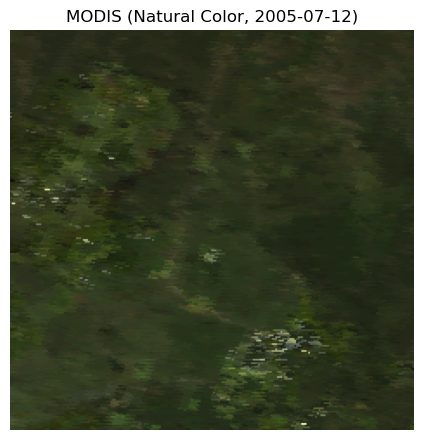

In [18]:
adapter_ts.satimg_view_opt = SatImgViewOpt.NATURAL_COLOR
adapter_ts.showSatImage(IMG_ID, figsize=(4.5, 4.5))

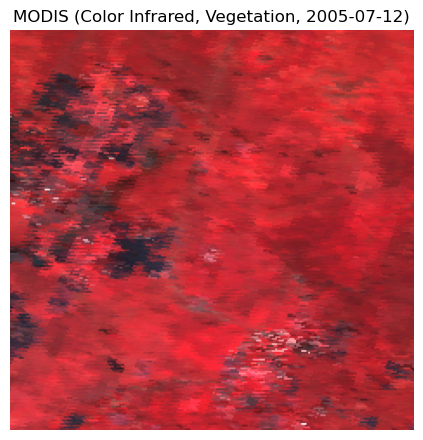

In [19]:
adapter_ts.satimg_view_opt = SatImgViewOpt.CIR
adapter_ts.showSatImage(IMG_ID, figsize=(4.5, 4.5))

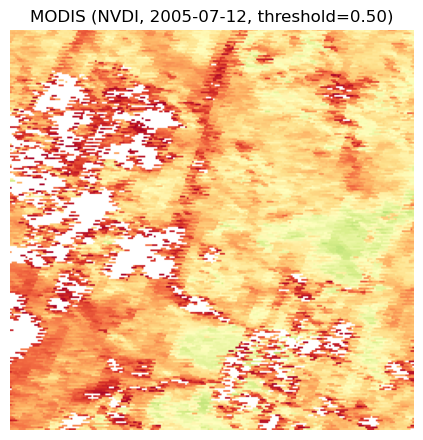

In [20]:
adapter_ts.satimg_view_opt = SatImgViewOpt.NDVI
adapter_ts.ndvi_view_threshold = .5
adapter_ts.showSatImage(IMG_ID, figsize=(4.5, 4.5))

### Fire Labels (MTBS)

Start event: 'Processing fire labels (MTBS)'.
Finnish event: 'Processing fire labels (MTBS)'. It takes 0.00s.


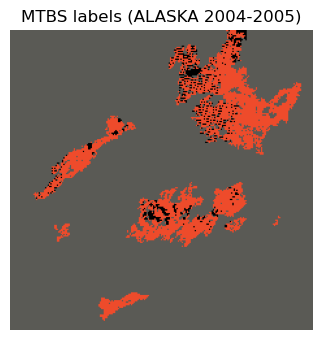

In [21]:
adapter_ts.showFireLabels(id_bands=range(0, 2), figsize=(3.5, 3.5))

## Creating data sets

In [22]:
id_start_date = 0
adapter_ts.ds_start_date = adapter_ts.satimg_dates.iloc[id_start_date]['Date']
print('Data set start date {}'.format(adapter_ts.satimg_dates.iloc[id_start_date]['Date']))

Data set start date 2004-01-01


In [23]:
id_start_date = -1
print('Data set end date {}'.format(adapter_ts.satimg_dates.iloc[id_start_date]['Date']))
adapter_ts.ds_end_date = adapter_ts.satimg_dates.iloc[id_start_date]['Date']

Data set end date 2005-12-27


In [24]:
adapter_ts.createDataset()

ds_train = adapter_ts.getTrainingDataset()
ds_test = adapter_ts.getTestDataset()

PCA cumsum test, found explainable 60 latent factors
PCA cumsum test, found explainable 71 latent factors
PCA cumsum test, found explainable 56 latent factors
PCA cumsum test, found explainable 59 latent factors
PCA cumsum test, found explainable 73 latent factors
PCA cumsum test, found explainable 72 latent factors
PCA cumsum test, found explainable 71 latent factors


In [25]:
ts_train = ds_train[0]; label_train = ds_train[1]
ts_test = ds_test[0]; label_test = ds_test[1]

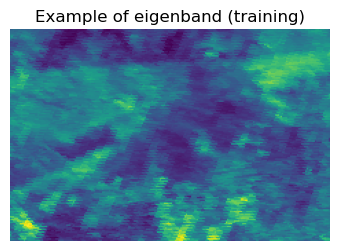

In [26]:
utils_plt.imshow(ts_train[10], title='Example of eigenband (training)', show=True)

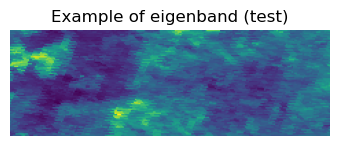

In [27]:
utils_plt.imshow(ts_test[10], title='Example of eigenband (test)', show=True)

### Training model

In [28]:
np = lazy_import('numpy')
xgboost = lazy_import('xgboost')

imblearn_metrics = lazy_import('imblearn.metrics')
sklearn_metrics = lazy_import('sklearn.metrics')

XGBClassifier = xgboost.XGBClassifier
classification_report_imbalanced = imblearn_metrics.classification_report_imbalanced
classification_report = sklearn_metrics.classification_report

In [29]:
tmp_shape_train = ts_train.shape
tmp_ts_train = ts_train.reshape(tmp_shape_train[0], -1).T

tmp_shape_test = ts_test.shape
tmp_ts_test = ts_test.reshape(tmp_shape_test[0], -1).T

In [30]:
label_train = label_train.reshape(-1)
label_test = label_test.reshape(-1)

Remove nan values

In [31]:
ts_train_nona = tmp_ts_train[~np.isnan(label_train)]
label_train_nona = label_train[~np.isnan(label_train)]

ts_test_nona = tmp_ts_test[~np.isnan(label_test)]
label_test_nona = label_test[~np.isnan(label_test)]

Train XGBoost classifier (without hyper parameter optimization)

In [32]:
xgb = XGBClassifier(objective='binary:logistic')
xgb.fit(ts_train_nona, label_train_nona)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

### Train data set

In [33]:
labels_pred = xgb.predict(ts_train_nona)

In [34]:
print('\n Report\n')
print(classification_report(label_train_nona, labels_pred))
print('\n Report (imbalanced)\n')
print(classification_report_imbalanced(label_train_nona, labels_pred))


 Report

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     29444
         1.0       0.89      0.91      0.90      5585

    accuracy                           0.97     35029
   macro avg       0.94      0.95      0.94     35029
weighted avg       0.97      0.97      0.97     35029


 Report (imbalanced)

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      0.98      0.91      0.98      0.94      0.90     29444
        1.0       0.89      0.91      0.98      0.90      0.94      0.89      5585

avg / total       0.97      0.97      0.92      0.97      0.94      0.90     35029



In [35]:
output = np.empty(shape=label_train.shape, dtype=label_train.dtype); output[:] = np.nan
output[~np.isnan(label_train)] = labels_pred

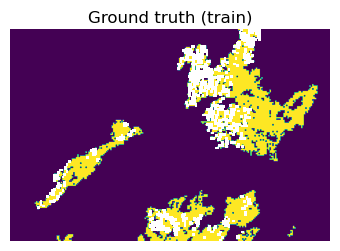

In [36]:
utils_plt.imshow(label_train.reshape(tmp_shape_train[1:3]), title='Ground truth (train)')

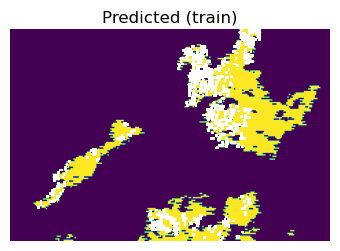

In [37]:
utils_plt.imshow(output.reshape(tmp_shape_train[1:3]), title='Predicted (train)')

### Test data set

In [38]:
labels_pred = xgb.predict(ts_test_nona)

In [39]:
print('\n Report\n')
print(classification_report(label_test_nona, labels_pred))
print('\n Report (imbalanced)\n')
print(classification_report_imbalanced(label_test_nona, labels_pred))


 Report

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     17223
         1.0       0.83      0.62      0.71       717

    accuracy                           0.98     17940
   macro avg       0.91      0.81      0.85     17940
weighted avg       0.98      0.98      0.98     17940


 Report (imbalanced)

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      0.99      0.62      0.99      0.79      0.64     17223
        1.0       0.83      0.62      0.99      0.71      0.79      0.59       717

avg / total       0.98      0.98      0.64      0.98      0.79      0.64     17940



In [40]:
output = np.empty(shape=label_test.shape, dtype=label_test.dtype); output[:] = np.nan
output[~np.isnan(label_test)] = labels_pred

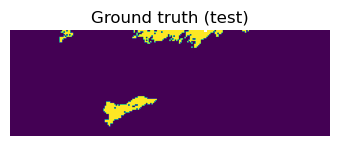

In [41]:
utils_plt.imshow(label_test.reshape(tmp_shape_test[1:3]), title='Ground truth (test)')

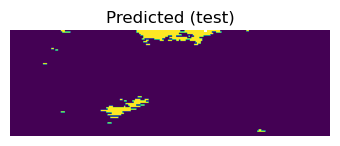

In [42]:
utils_plt.imshow(output.reshape(tmp_shape_test[1:3]), title='Predicted (test)')